In [20]:
#please install the following pip packages to run this code

#pip install modAL
#pip install scikit-learn
#pip install matplotlib
#pip install pandas
#pip install numpy


#Committee & uncerstainity sampling
from modAL.models import ActiveLearner
from modAL.models import Committee
from functools import partial

#the sampling strategies
from modAL.uncertainty import entropy_sampling, uncertainty_sampling, margin_sampling
from modAL.disagreement import vote_entropy_sampling, max_disagreement_sampling

#The algorithm for active learning
from sklearn.svm import SVC
import numpy as np
import pandas as pd

# Problem 1(Using pool based sampling here)
## This section also has all experiments related to pool based pooling

## Method for uncertainity sampling

In [21]:
#this uses pool based pooling
def active_learning_single(X,y,n_queries,n_keep,query_strategy):
    idx_initial = np.random.choice(range(len(X)), size=n_keep, replace=False)
    idx_rem = [i for i in range(len(X)) if i not in idx_initial]

    x_initial = X[idx_initial]
    y_initial = y[idx_initial]

    x_rem = X[idx_rem]
    y_rem = y[idx_rem]
    
    if query_strategy == 'random':
            act_learner = ActiveLearner(estimator=SVC(probability=True),X_training=x_initial,y_training=y_initial)
    else:
            act_learner = ActiveLearner(estimator=SVC(probability=True),X_training=x_initial,y_training=y_initial,query_strategy=query_strategy)
    
    performance_track = []
    performance_track.append(act_learner.score(x_tes,y_tes))
    
    for i in range(n_queries):
        #picking out next 10% of data
        if query_strategy=='random':
            idx_next_10 = np.random.choice(range(x_rem.shape[0]),size=int(x.shape[0]*.1),replace=False)
            x_rem_10 = x_rem[idx_next_10]
            y_rem_10 = y_rem[idx_next_10]
            act_learner.teach(x_rem_10,y_rem_10)
            
            x_rem = np.delete(x_rem, idx_next_10, 0) 
            y_rem = np.delete(y_rem, idx_next_10, 0)
        
        else:
            query_idx, query_instance = act_learner.query(x_rem)
            
            #print(query_idx.shape)
            act_learner.teach(x_rem[query_idx], y_rem[query_idx])
            
            #removing the specific point
            x_rem = np.delete(x_rem, query_idx, 0)
            y_rem = np.delete(y_rem, query_idx, 0)
        
        #removing the 10% data
        performance_track.append(act_learner.score(x_tes,y_tes))
    return performance_track

## Dataset Loading & Preprocessing

In [22]:
data_train = pd.read_csv('Data/pendigits.tra').to_numpy()
data_test = pd.read_csv('Data/pendigits.tes').to_numpy()

#data_for_training
x = data_train[:,:16]
y = data_train[:,16]

#data_for_testing
x_tes = data_test[:,:16]
y_tes = data_test[:,16]

## Method for QBC

In [23]:
def active_learning_committee(X,y,n_queries,n_committee,n_keep,query_strategy):    
    idx_initial = np.random.choice(range(len(X)), size=n_keep, replace=False)
    idx_rem = [i for i in range(len(X)) if i not in idx_initial]
    
    x_initial = X[idx_initial]
    y_initial = y[idx_initial]

    x_rem = X[idx_rem]
    y_rem = y[idx_rem]
    
    learners = []
    for i in range(n_committee):
        learner = ActiveLearner(estimator=SVC(probability=True),X_training=x_initial,y_training=y_initial)
        learners.append(learner)
        
    if query_strategy=='random':
        committee = Committee(learner_list=learners)
    else:
        committee = Committee(learner_list=learners,query_strategy=query_strategy)
        
    comm_perform = []
    comm_perform.append(committee.score(x_tes,y_tes))
    
    for i in range(n_queries):
        
        if query_strategy == 'random':
            idx_next_10 = np.random.choice(range(x_rem.shape[0]),size=int(x.shape[0]*0.1),replace=False)
            x_rem_10 = x_rem[idx_next_10]
            y_rem_10 = y_rem[idx_next_10]
            committee.teach(x_rem_10,y_rem_10)
            
            #removing the 10% data
            x_rem = np.delete(x_rem, idx_next_10, 0)
            y_rem = np.delete(y_rem, idx_next_10, 0)
        
        else:
            query_idx,q_inst = committee.query(x_rem)
            #print(query_idx.shape)
            #print(query_idx)
            committee.teach(x_rem[query_idx],y_rem[query_idx])
            #removing the specific point
            x_rem = np.delete(x_rem,query_idx,0)
            y_rem = np.delete(y_rem,query_idx,0)  
        
        comm_perform.append(committee.score(x_tes,y_tes))
        
    return comm_perform

# Evaluation

In [24]:
#Results on test data when we train on the whole dataset
out = SVC().fit(x,y)
print(out.score(x_tes,y_tes))

0.9816985987989706


In [25]:
#uncertainity evaluation, n_queries is 4 as with every query the number of points increase by 10%
# A batch of 10% points is queried at all steps
entropy_batch_sampling = partial(entropy_sampling,n_instances=int(x.shape[0]*0.1))
least_confident_batch_sampling = partial(uncertainty_sampling,n_instances=int(x.shape[0]*0.1))
margin_batch_sampling = partial(margin_sampling,n_instances=int(x.shape[0]*0.1))

random_track = active_learning_single(x,y,4,int(x.shape[0]*0.1),'random')
margin_sampling_track = active_learning_single(x,y,4,int(x.shape[0]*0.1),margin_batch_sampling)
entropy_track = active_learning_single(x,y,4,int(x.shape[0]*0.1),entropy_batch_sampling)
least_confident_track = active_learning_single(x,y,4,int(x.shape[0]*0.1),least_confident_batch_sampling)

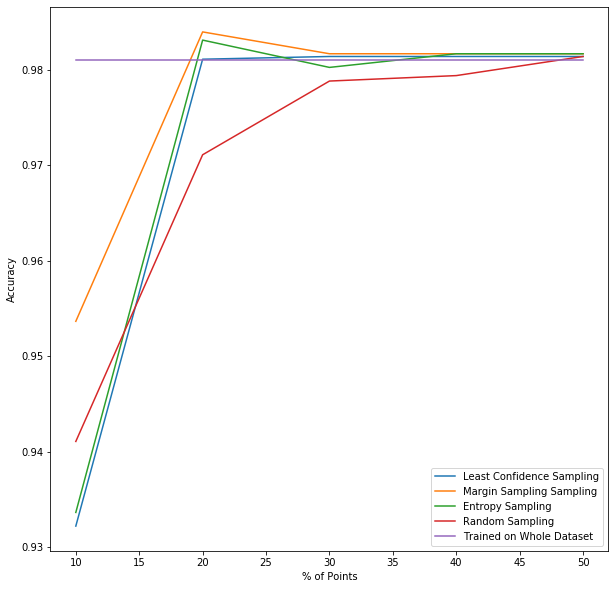

In [27]:
#plot for uncetainity sampling
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
x_axis = np.linspace(10.0,50.0,5)
plt.plot(x_axis,least_confident_track,label='Least Confidence Sampling')
plt.plot(x_axis,margin_sampling_track,label='Margin Sampling Sampling')
plt.plot(x_axis,entropy_track,label='Entropy Sampling')
plt.plot(x_axis,random_track,label='Random Sampling')
plt.plot(x_axis,[0.981 for i in range(5)],label ='Trained on Whole Dataset')
plt.xlabel('% of Points')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [28]:
#QBC evaluation, n_queries is 4 as with every query the number of points increase by 10%
kl_batch_sampling = partial(max_disagreement_sampling,n_instances=int(x.shape[0]*0.1))
vote_entropy_batch_sampling = partial(vote_entropy_sampling,n_instances=int(x.shape[0]*0.1))


kl_track = active_learning_committee(x,y,4,5,int(x.shape[0]*0.1),kl_batch_sampling)
vote_track = active_learning_committee(x,y,4,5,int(x.shape[0]*0.1),vote_entropy_batch_sampling)
random_committee_track = active_learning_committee(x,y,4,5,int(x.shape[0]*0.1),'random')

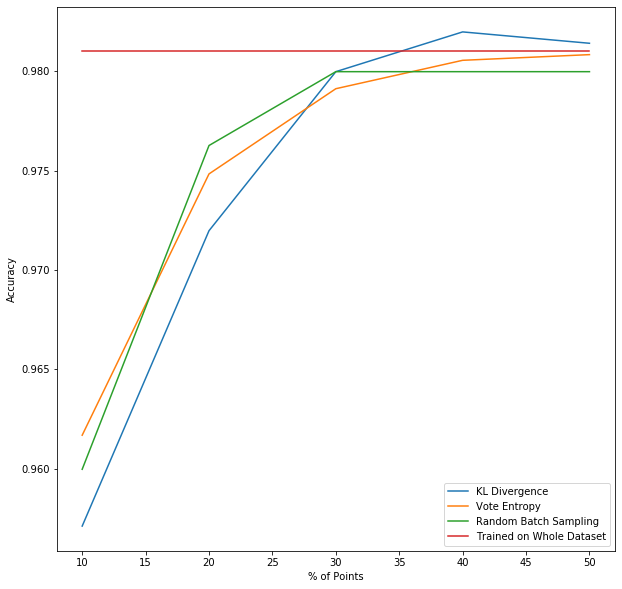

In [29]:
plt.figure(figsize=(10,10))
x_axis = np.linspace(10.0,50.0,5)
plt.plot(x_axis,kl_track,label='KL Divergence')
plt.plot(x_axis,vote_track,label='Vote Entropy')
plt.plot(x_axis,random_committee_track,label='Random Batch Sampling')
plt.plot(x_axis,[0.981 for i in range(5)],label ='Trained on Whole Dataset')
plt.xlabel('% of Points')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [30]:
print(least_confident_track)
print(margin_sampling_track)
print(entropy_track)
print(random_track)

[0.9322276236774378, 0.9811266800114383, 0.9814126394052045, 0.9814126394052045, 0.9814126394052045]
[0.9536745782098942, 0.9839862739490992, 0.9816985987989706, 0.9816985987989706, 0.9816985987989706]
[0.9336574206462682, 0.983128395767801, 0.9802688018301401, 0.9816985987989706, 0.9816985987989706]
[0.9410923648841865, 0.9711181012296254, 0.9788390048613097, 0.9794109236488419, 0.9814126394052045]


In [31]:
print(kl_track)
print(vote_track)
print(random_committee_track)

[0.9571060909350873, 0.9719759794109236, 0.979982842436374, 0.9819845581927367, 0.9814126394052045]
[0.9616814412353446, 0.9748355733485845, 0.9791249642550758, 0.9805547612239062, 0.9808407206176722]
[0.959965684872748, 0.9762653703174149, 0.979982842436374, 0.979982842436374, 0.979982842436374]
